In [ ]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import os


In [ ]:
# Configurações visuais
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')

In [41]:
PATH_BQ = "data/bq_2022_trusted.parquet"
PATH_MICRO = "data/inep_2022_trusted.parquet"
PATH_2010 = "data/sidra_2010_trusted.parquet"
OUT_DIR = "data/analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [ ]:
# Carregar arquivos

try:
    df_bq = pd.read_parquet(PATH_BQ)
    print("bq ok", df_bq.shape)
except Exception as e:
    raise RuntimeError(f"Erro lendo bq_2022.csv: {e}")

# microdados parquet
try:
    df_micro = pd.read_parquet(PATH_MICRO)  # requer pyarrow or fastparquet
    print("microdados ok", df_micro.shape)
except Exception as e:
    print("Não foi possível ler parquet diretamente:", e)
    df_micro = None

# 2010 
try:
    df_2010 = pd.read_parquet(PATH_2010)
    print("2010 ok", df_2010.shape)
except Exception as e:
    df_2010 = None
    print("Não carregou 2010:", e)

bq ok (27850, 7)
microdados ok (178346, 32)
2010 ok (5565, 5)


In [43]:
# Padronização básica do df_bq
df = df_bq.copy()
df.columns = df.columns.str.strip().str.lower()
# coerção numérica
for c in ['populacao_homens','populacao_mulheres','populacao_total']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False), errors='coerce').fillna(0).astype(int)
# padroniza cor_raca e nome_municipio, sigla_uf
df['cor_raca'] = df['cor_raca'].astype(str).str.strip().str.title()
df['nome_municipio'] = df['nome_municipio'].astype(str).str.strip()
df['sigla_uf'] = df['sigla_uf'].astype(str).str.strip().str.upper()

df.head()

,id_municipio,nome_municipio,sigla_uf,cor_raca,populacao_homens,populacao_mulheres,populacao_total
0,1100015,Alta Floresta D'Oeste,RO,Amarela,1654,1544,3198
1,1100015,Alta Floresta D'Oeste,RO,Branca,1654,1544,3198
2,1100015,Alta Floresta D'Oeste,RO,Indígena,1654,1544,3198
3,1100015,Alta Floresta D'Oeste,RO,Parda,1654,1544,3198
4,1100015,Alta Floresta D'Oeste,RO,Preta,1654,1544,3198


In [44]:
# Agregados e métricas iniciais a partir de df_bq
# Proporções e soma por município
df['pct_mulheres_no_mun'] = df['populacao_mulheres'] / df['populacao_total'].replace({0:np.nan})
df['pct_raca_sobre_mulheres_mun'] = df['populacao_mulheres'] / df.groupby('id_municipio')['populacao_mulheres'].transform('sum').replace({0:np.nan})

# Soma nacional por raça (mulheres)
agg_raca = df.groupby('cor_raca', as_index=False)['populacao_mulheres'].sum().sort_values('populacao_mulheres', ascending=False)
agg_raca['pct_sobre_mulheres_total'] = agg_raca['populacao_mulheres'] / agg_raca['populacao_mulheres'].sum()

# Índice Shannon por município (diversidade racial feminina)
# Índice escolhido para analisar a diversidade, considerando:
# tanto o declarado quanto a uniformidade
def shannon(counts):
    p = np.array(counts, dtype=float)
    s = p.sum()
    if s == 0:
        return 0.0
    p = p / s
    return entropy(p)
shannon = df.groupby('id_municipio').apply(lambda g: shannon(g['populacao_mulheres'])).reset_index(name='shannon_mulheres')
# junta nome/uf
mun_info = df[['id_municipio','nome_municipio','sigla_uf']].drop_duplicates(subset='id_municipio')
shannon = shannon.merge(mun_info, on='id_municipio', how='left')

# salvar agregados
agg_raca.to_csv(os.path.join(OUT_DIR, 'agg_raca_mulheres_nacional.csv'), index=False)
shannon.to_csv(os.path.join(OUT_DIR, 'shannon_mulheres_por_municipio.csv'), index=False)
print("Agregados salvos em", OUT_DIR)


Agregados salvos em data/analysis_outputs


/tmp/ipykernel_2714/847479601.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shannon = df.groupby('id_municipio').apply(lambda g: shannon(g['populacao_mulheres'])).reset_index(name='shannon_mulheres')


In [46]:
# Preparação dos microdados INEP: agregação por município e extração de matrículas femininas por nível
if df_micro is not None:
    dfm = df_micro.copy()
    # padroniza colunas caso estejam maiúsculas (conforme sua listagem)
    dfm.columns = dfm.columns.str.strip().str.lower()
    # colunas chave: co_municipio (código), qt_mat_bas_fem, qt_mat_med, qt_mat_eja, etc.
    # Ajuste nomes se necessário: aqui assumo qt_mat_bas_fem, qt_mat_med, qt_mat_eja, qt_mat_fund...
    # Agregar por município: somar matrículas femininas por nível
    agg_cols = [c for c in dfm.columns if c.startswith('qt_mat_') and ('_fem' in c or c.endswith('_fem'))]
    # caso algumas colunas tenham nomes exatos:
    possible = ['qt_mat_bas_fem','qt_mat_med','qt_mat_eja','qt_mat_fund']
    for c in possible:
        if c in dfm.columns and c not in agg_cols:
            agg_cols.append(c)
    # Se não encontrou colunas específicas, liste manualmente:
    print("Colunas de matrícula identificadas para agregação:", agg_cols)
    dfm_agg = dfm.groupby('id_municipio')[agg_cols].sum().reset_index().rename(columns={'co_municipio':'id_municipio'})
    # Normalizar id tipo int
    dfm_agg['id_municipio'] = dfm_agg['id_municipio'].astype(int)
    dfm_agg.to_csv(os.path.join(OUT_DIR,'micro_agg_matriculas_fem.csv'), index=False)
    print("Microdados agregados salvos.")
else:
    print("Microdados não disponíveis - pule essa célula ou instale pyarrow para ler o parquet.")


Colunas de matrícula identificadas para agregação: ['qt_mat_bas_fem', 'qt_mat_med', 'qt_mat_eja', 'qt_mat_fund']
Microdados agregados salvos.


In [47]:
# Merge entre df (bq) e microdados agregados (matrículas)
# Use apenas se gerou dfm_agg
if df_micro is not None:
    dfm_agg = pd.read_csv(os.path.join(OUT_DIR,'micro_agg_matriculas_fem.csv'))
    dfm_agg['id_municipio'] = dfm_agg['id_municipio'].astype(int)
    df_merge = df.merge(dfm_agg, on='id_municipio', how='left')
else:
    df_merge = df.copy()
print("Merged shape:", df_merge.shape)
df_merge.head()

Merged shape: (27850, 13)


,id_municipio,nome_municipio,sigla_uf,cor_raca,populacao_homens,populacao_mulheres,populacao_total,pct_mulheres_no_mun,pct_raca_sobre_mulheres_mun,qt_mat_bas_fem,qt_mat_med,qt_mat_eja,qt_mat_fund
0,1100015,Alta Floresta D'Oeste,RO,Amarela,1654,1544,3198,0.48,0.20,2493.00,840.00,200.00,3335.00
1,1100015,Alta Floresta D'Oeste,RO,Branca,1654,1544,3198,0.48,0.20,2493.00,840.00,200.00,3335.00
2,1100015,Alta Floresta D'Oeste,RO,Indígena,1654,1544,3198,0.48,0.20,2493.00,840.00,200.00,3335.00
3,1100015,Alta Floresta D'Oeste,RO,Parda,1654,1544,3198,0.48,0.20,2493.00,840.00,200.00,3335.00
4,1100015,Alta Floresta D'Oeste,RO,Preta,1654,1544,3198,0.48,0.20,2493.00,840.00,200.00,3335.00


In [48]:
# Criação de DataFrame apenas com capitais
# Padronizar nomes
df1 = df.rename(columns=lambda c: c.strip().lower())

# Lista oficial das capitais + DF
capitais = {
    "Rio Branco": "AC",
    "Maceió": "AL",
    "Macapá": "AP",
    "Manaus": "AM",
    "Salvador": "BA",
    "Fortaleza": "CE",
    "Brasília": "DF",
    "Vitória": "ES",
    "Goiânia": "GO",
    "São Luís": "MA",
    "Cuiabá": "MT",
    "Campo Grande": "MS",
    "Belo Horizonte": "MG",
    "Belém": "PA",
    "João Pessoa": "PB",
    "Curitiba": "PR",
    "Recife": "PE",
    "Teresina": "PI",
    "Rio de Janeiro": "RJ",
    "Natal": "RN",
    "Porto Alegre": "RS",
    "Porto Velho": "RO",
    "Boa Vista": "RR",
    "Florianópolis": "SC",
    "São Paulo": "SP",
    "Aracaju": "SE",
    "Palmas": "TO",
}

# Filtrar apenas capitais
df_capitais = df1[
    (df1['nome_municipio'].isin(capitais.keys())) &
    (df1['sigla_uf'].isin(capitais.values()))
]

# Selecionar colunas pedidas
df_capitais = df_capitais[['id_municipio', 'nome_municipio', 'sigla_uf']].drop_duplicates()

df_capitais

,id_municipio,nome_municipio,sigla_uf
80,1100205,Porto Velho,RO
330,1200401,Rio Branco,AC
555,1302603,Manaus,AM
690,1400100,Boa Vista,RR
845,1501402,Belém,PA
1515,1600303,Macapá,AP
2215,1721000,Palmas,TO
3175,2111300,São Luís,MA
4410,2211001,Teresina,PI
4745,2304400,Fortaleza,CE


### **CAPÍTULO 1 — Panorama geral da alfabetização feminina no Brasil**

Perguntas que você definiu:

1. **Qual é a distribuição da alfabetização feminina no Brasil em 2022?**
2. **Como a alfabetização feminina varia entre regiões (Norte, Nordeste, Sul, etc.)?**
3. **Quais capitais concentram os maiores e menores índices de alfabetização entre mulheres?**
4. **Como é distribuída a população feminina alfabetizada por raça dentro dos municípios e capitais?**

**Objetivo do capítulo:**
Criar o retrato inicial. Gráficos + mapas.
Esse capítulo introduz a desigualdade antes de aprofundá-la.

In [49]:
# 1) Distribuição da alfabetização feminina
# Aqui assumimos que "populacao_mulheres_alfabetizadas" não existe - então exemplo usando pct_mulheres_no_mun
# Top 10 capitais com maior/menor pct_mulheres_no_mun (agregando por município -> tomar apenas uma linha por mun)
df_mun = df.groupby(['id_municipio','nome_municipio','sigla_uf'], as_index=False).agg({
    'populacao_mulheres':'sum',
    'populacao_homens':'sum',
    'populacao_total':'sum'
})
df_mun['pct_mulheres'] = df_mun['populacao_mulheres'] / df_mun['populacao_total'].replace({0:np.nan})
top10_high = df_mun.sort_values('pct_mulheres', ascending=False).head(10)
top10_low = df_mun.sort_values('pct_mulheres').head(10)
print("Top 10 - maior pct mulheres (proxy):")
print(top10_high[['nome_municipio','sigla_uf','pct_mulheres']])
print("\nTop 10 - menor pct mulheres (proxy):")
print(top10_low[['nome_municipio','sigla_uf','pct_mulheres']])

Top 10 - maior pct mulheres (proxy):
             nome_municipio sigla_uf  pct_mulheres
2615  Itambé do Mato Dentro       MG          0.57
2753           Nacip Raydan       MG          0.57
5002        São José do Sul       RS          0.56
4194              Pranchita       PR          0.55
3031               Serranos       MG          0.54
4097               Leópolis       PR          0.54
4967   Santa Cecília do Sul       RS          0.54
3934       Ariranha do Ivaí       PR          0.54
3040              Tabuleiro       MG          0.54
4382        Coronel Martins       SC          0.54

Top 10 - menor pct mulheres (proxy):
          nome_municipio sigla_uf  pct_mulheres
3724            Pracinha       SP          0.22
3743         Reginópolis       SP          0.23
3566             Lavínia       SP          0.24
3589     Marabá Paulista       SP          0.24
3320            Balbinos       SP          0.26
3660            Pacaembu       SP          0.28
3369               Caiuá    

In [57]:
uf_to_region = {
    'AC': 'Norte', 'AL': 'Nordeste', 'AP': 'Norte', 'AM': 'Norte', 'BA': 'Nordeste',
    'CE': 'Nordeste', 'DF': 'Centro-Oeste', 'ES': 'Sudeste', 'GO': 'Centro-Oeste',
    'MA': 'Nordeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MG': 'Sudeste',
    'PA': 'Norte', 'PB': 'Nordeste', 'PR': 'Sul', 'PE': 'Nordeste', 'PI': 'Nordeste',
    'RJ': 'Sudeste', 'RN': 'Nordeste', 'RS': 'Sul', 'RO': 'Norte', 'RR': 'Norte',
    'SC': 'Sul', 'SP': 'Sudeste', 'SE': 'Nordeste', 'TO': 'Norte'
}
df['region'] = df['sigla_uf'].map(uf_to_region).fillna('Desconhecida')
df['region'].value_counts()

region
Nordeste        8970
Sudeste         8340
Sul             5955
Centro-Oeste    2335
Norte           2250
Name: count, dtype: int64

In [58]:
# Agregação por região
df_mun['region'] = df_mun['sigla_uf'].map(uf_to_region)
region_agg = df_mun.groupby('region')['pct_mulheres'].agg(['mean','median','count']).reset_index()
region_agg

,region,mean,median,count
0,Centro-Oeste,0.49,0.49,467
1,Nordeste,0.49,0.49,1794
2,Norte,0.49,0.49,450
3,Sudeste,0.49,0.49,1668
4,Sul,0.49,0.49,1191


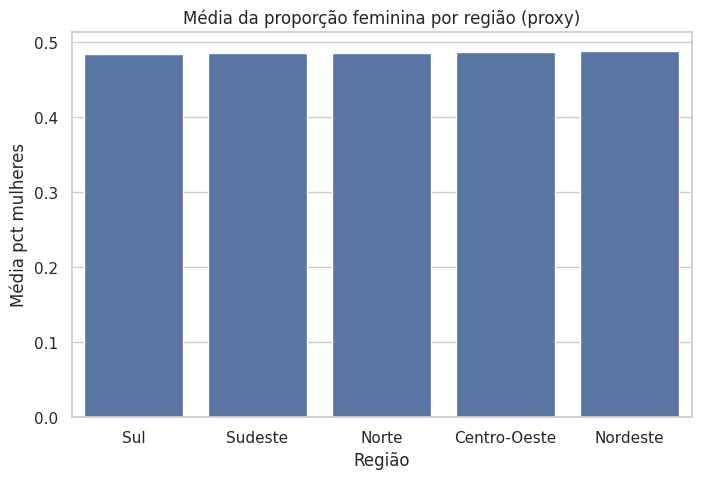

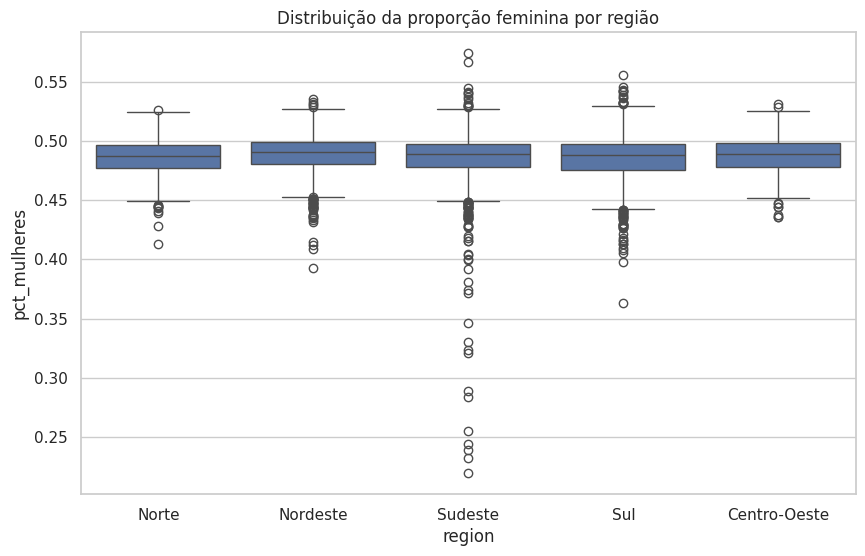

In [52]:
# Distribuição por região
plt.figure(figsize=(8,5))
sns.barplot(data=region_agg.sort_values('mean'), x='region', y='mean')
plt.title('Média da proporção feminina por região (proxy)')
plt.ylabel('Média pct mulheres')
plt.xlabel('Região')
plt.show()

# Boxplot pct_mulheres por região
plt.figure(figsize=(10,6))
sns.boxplot(data=df_mun, x='region', y='pct_mulheres')
plt.title('Distribuição da proporção feminina por região')
plt.show()

### **CAPÍTULO 2 — Desigualdades raciais entre mulheres alfabetizadas**

Perguntas selecionadas:

8. **Em quais regiões a desigualdade racial entre mulheres alfabetizadas é mais intensa?**
9. **Existe uma “correlação regional” entre proporção racial de mulheres e menor alfabetização feminina?**

**Objetivo:**
Mostrar que desigualdade racial não é homogênea — é territorial.
Aqui entram correlações, heatmaps, clusters.

In [67]:
# Funções utilitárias (Gini ponderado)
def weighted_gini(values, weights):
    """
    O Gini é usado para medir desigualdade de renda, mas serve igualmente para desigualdade de taxas 
    de alfabetização entre grupos raciais.
    
    Gini coefficient weighted.
    values: array-like of values (ex: taxas por grupo)
    weights: array-like of weights (ex: população feminina do grupo)
    """

    v = np.array(values, dtype=float)
    w = np.array(weights, dtype=float)

    mask = (w > 0) & (~np.isnan(v))
    v = v[mask]
    w = w[mask]

    if len(v) == 0:
        return np.nan

    order = np.argsort(v)
    v = v[order]
    w = w[order]

    cumw = np.cumsum(w)
    cumv = np.cumsum(v * w)

    sumw = cumw[-1]
    sumvw = cumv[-1]

    if sumw == 0 or sumvw == 0:
        return np.nan

    relcumw = cumw / sumw
    relcumv = cumv / sumvw

    B = np.sum(relcumv[:-1] * (relcumw[1:] - relcumw[:-1]))
    G = 1 - 2 * B

    return float(G)

In [69]:
# ------------------------------------------------------------
# DESIGUALDADE RACIAL ENTRE MULHERES ALFABETIZADAS POR REGIÃO
# ------------------------------------------------------------



df_bq['region'] = df_bq['sigla_uf'].map(uf_to_region)


# -------------------------------------------------------------------
# Taxa de alfabetização feminina por raça (df_bq já possui valores)
# -------------------------------------------------------------------
# Fórmula:
# taxa_alf_fem = populacao_mulheres / populacao_total

df_bq['taxa_alf_fem'] = (
    df_bq['populacao_mulheres'] /
    df_bq['populacao_total'].replace({0: np.nan})
)


# ---------------------------------------------------
# Agregação por REGIÃO x RAÇA com pesos populacionais
# ---------------------------------------------------
grp = (
    df_bq
    .groupby(['region', 'cor_raca'], as_index=False)
    .agg({
        'populacao_mulheres': 'sum',
        'populacao_total': 'sum'
    })
)

grp['taxa_alf_fem_raca'] = (
    grp['populacao_mulheres'] /
    grp['populacao_total'].replace({0: np.nan})
)


# -------------------------------------------------------
# Cálculo das métricas de desigualdade racial por região
# -------------------------------------------------------
results = []

for region, g in grp.groupby('region'):
    taxas = g['taxa_alf_fem_raca'].values
    pesos = g['populacao_total'].values  # usar população total como peso

    rng = np.nanmax(taxas) - np.nanmin(taxas)
    std = np.nanstd(taxas)
    mean = np.nanmean(taxas)
    cv = std / mean if mean > 0 else np.nan
    gini = weighted_gini(taxas, pesos)

    results.append({
        'region': region,
        'range': rng,
        'std': std,
        'mean': mean,
        'cv': cv,
        'gini_weighted': gini,
        'num_racas': len(g)
    })

df_desigualdade = pd.DataFrame(results).sort_values('gini_weighted', ascending=False)

display(df_desigualdade)



,region,range,std,mean,cv,gini_weighted,num_racas
0,Centro-Oeste,0.00,0.00,0.49,0.00,0.20,5
1,Nordeste,0.00,0.00,0.50,0.00,0.20,5
2,Norte,0.00,0.00,0.49,0.00,0.20,5
3,Sudeste,0.00,0.00,0.49,0.00,0.20,5
4,Sul,0.00,0.00,0.49,0.00,0.20,5


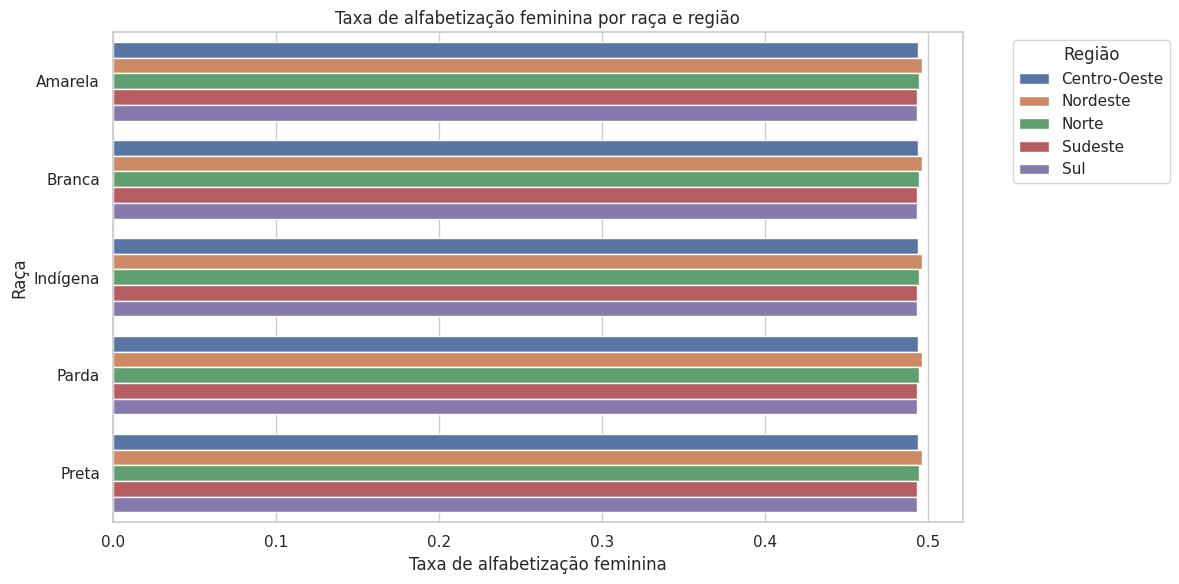

In [70]:
# -------------------------------------
# Visualização: taxa por raça/região
# -------------------------------------
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

plt.figure(figsize=(12,6))
sns.barplot(
    data=grp.sort_values(['region','taxa_alf_fem_raca'], ascending=[True, False]),
    x='taxa_alf_fem_raca',
    y='cor_raca',
    hue='region'
)
plt.title("Taxa de alfabetização feminina por raça e região")
plt.xlabel("Taxa de alfabetização feminina")
plt.ylabel("Raça")
plt.legend(title="Região", bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

In [72]:
# ----------------------------------------
# Taxas masculina e feminina por linha
# ----------------------------------------
df_bq['taxa_mulheres'] = (
    df_bq['populacao_mulheres'] / 
    df_bq['populacao_total'].replace({0: np.nan})
)

df_bq['taxa_homens'] = (
    df_bq['populacao_homens'] / 
    df_bq['populacao_total'].replace({0: np.nan})
)

# ------------------------
# GAP de desigualdade
# ------------------------
df_bq['gap_abs'] = df_bq['taxa_mulheres'] - df_bq['taxa_homens']
df_bq['gap_rel'] = df_bq['gap_abs'] / df_bq['taxa_homens'].replace({0: np.nan})

# ------------------------------------------
# Resumo por região (média, std, extremos)
# ------------------------------------------
region_gap = (
    df_bq.groupby('region')
    .agg({
        'gap_abs': ['mean', 'std', 'min', 'max'],
        'taxa_mulheres': 'mean',
        'taxa_homens': 'mean'
    })
)

region_gap.columns = ['_'.join(col).strip() for col in region_gap.columns.values]
region_gap = region_gap.reset_index()

display(region_gap.sort_values('gap_abs_mean', ascending=False))

,region,gap_abs_mean,gap_abs_std,gap_abs_min,gap_abs_max,taxa_mulheres_mean,taxa_homens_mean
1,Nordeste,-0.02,0.03,-0.21,0.07,0.49,0.51
0,Centro-Oeste,-0.03,0.03,-0.13,0.06,0.49,0.51
2,Norte,-0.03,0.03,-0.17,0.05,0.49,0.51
3,Sudeste,-0.03,0.05,-0.56,0.15,0.49,0.51
4,Sul,-0.03,0.04,-0.27,0.11,0.49,0.51


In [73]:
# ---------------------------------------
#   Ranking dos municípios mais desiguais
# ---------------------------------------
municipios_gap = (
    df_bq
    .groupby(['id_municipio','nome_municipio','sigla_uf'])[['gap_abs','gap_rel']]
    .mean()
    .reset_index()
)

top_10_desigualdade = municipios_gap.sort_values('gap_abs', ascending=False).head(10)
display(top_10_desigualdade)

,id_municipio,nome_municipio,sigla_uf,gap_abs,gap_rel
2615,3132800,Itambé do Mato Dentro,MG,0.15,0.35
2753,3144201,Nacip Raydan,MG,0.13,0.30
5002,4318614,São José do Sul,RS,0.11,0.25
4194,4120358,Pranchita,PR,0.09,0.20
3031,3167004,Serranos,MG,0.09,0.20
4097,4113403,Leópolis,PR,0.09,0.19
4967,4316733,Santa Cecília do Sul,RS,0.08,0.18
3934,4101853,Ariranha do Ivaí,PR,0.08,0.18
3040,3167905,Tabuleiro,MG,0.08,0.18
4382,4204459,Coronel Martins,SC,0.08,0.18


/tmp/ipykernel_2714/3404143595.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


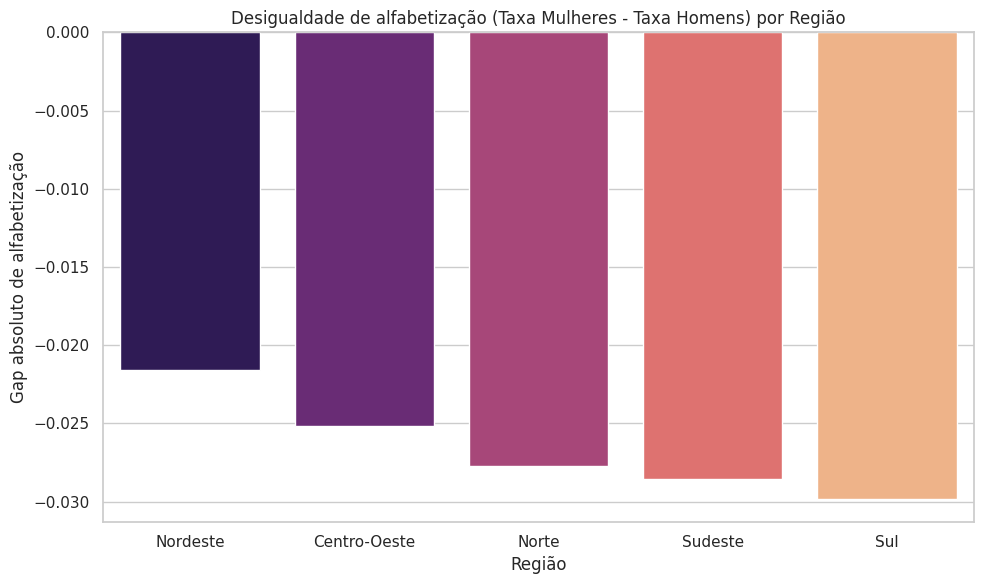

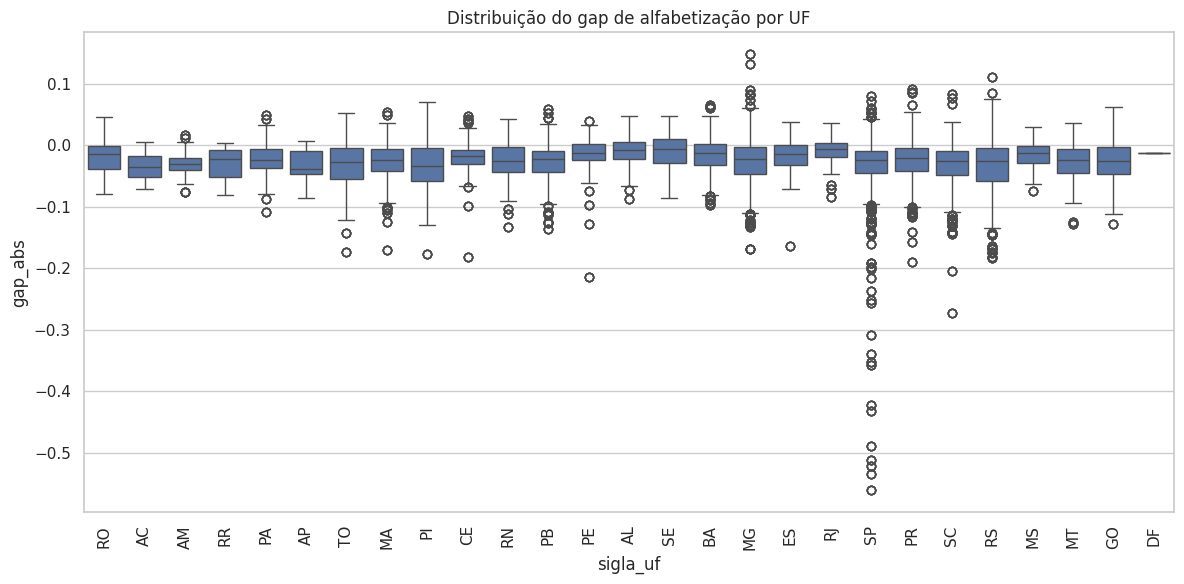

In [75]:
# -----------------------------------------
#  Visualização: desigualdade por região
# -----------------------------------------
plt.figure(figsize=(10,6))
sns.barplot(
    data=region_gap.sort_values('gap_abs_mean', ascending=False),
    x='region', y='gap_abs_mean', palette='magma'
)
plt.title("Desigualdade de alfabetização (Taxa Mulheres - Taxa Homens) por Região")
plt.xlabel("Região")
plt.ylabel("Gap absoluto de alfabetização")
plt.tight_layout()
plt.show()

# -----------------------------------------
# 7) Visualização: distribuição do gap por UF
# -----------------------------------------
plt.figure(figsize=(12,6))
sns.boxplot(data=df_bq, x='sigla_uf', y='gap_abs')
plt.title("Distribuição do gap de alfabetização por UF")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

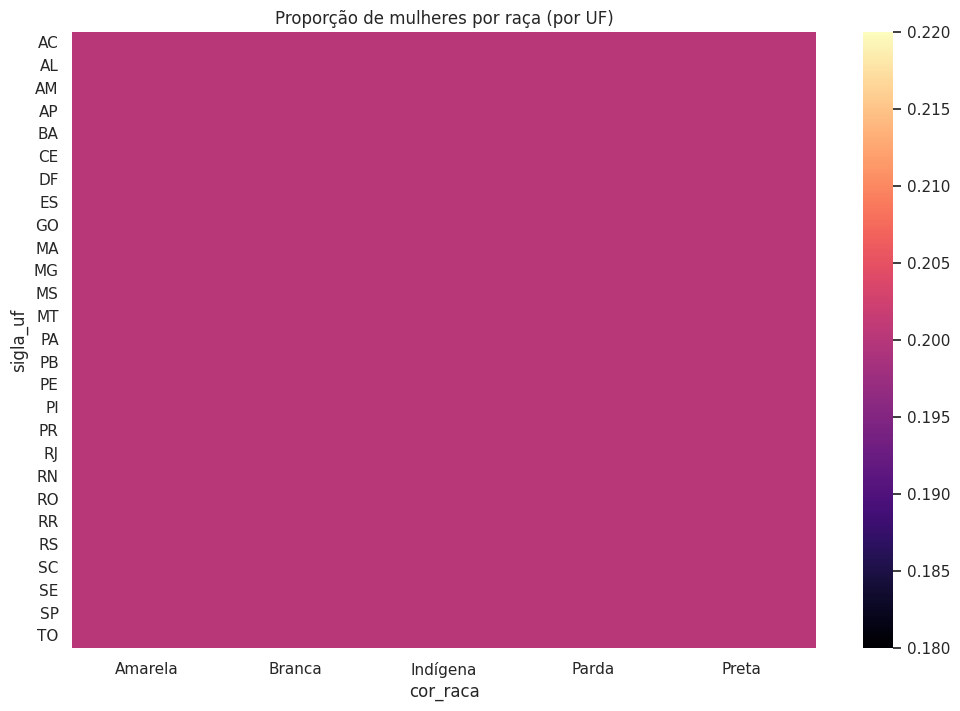

In [53]:
# Agregar por UF x cor_raca: proporção de mulheres de cada raça
uf_raca = df.groupby(['sigla_uf','cor_raca'], as_index=False)['populacao_mulheres'].sum()
uf_total_mulheres = df.groupby('sigla_uf', as_index=False)['populacao_mulheres'].sum().rename(columns={'populacao_mulheres':'total_mulheres'})
uf_raca = uf_raca.merge(uf_total_mulheres, on='sigla_uf', how='left')
uf_raca['pct_raca_sobre_mulheres_uf'] = uf_raca['populacao_mulheres'] / uf_raca['total_mulheres'].replace({0:np.nan})
# pivot para heatmap
pivot = uf_raca.pivot(index='sigla_uf', columns='cor_raca', values='pct_raca_sobre_mulheres_uf').fillna(0)
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap='magma')
plt.title('Proporção de mulheres por raça (por UF)')
plt.show()

In [54]:
# Correlação entre pct_preta (por mun) e pct_mulheres (proxy de alfabetização se tiver taxa use ela)
# Primeiro calc pct_preta por município
pct_preta_mun = df[df['cor_raca'].str.lower().str.contains('preta', na=False)].groupby('id_municipio')['populacao_mulheres'].sum().reset_index(name='mulheres_preta')
total_mulheres_mun = df.groupby('id_municipio')['populacao_mulheres'].sum().reset_index(name='total_mulheres')
corr_df = pct_preta_mun.merge(total_mulheres_mun, on='id_municipio', how='left')
corr_df['pct_preta'] = corr_df['mulheres_preta'] / corr_df['total_mulheres'].replace({0:np.nan})
# merge com df_mun (pct_mulheres)
corr_df = corr_df.merge(df_mun[['id_municipio','pct_mulheres','nome_municipio','sigla_uf','region']], on='id_municipio', how='left')
corr = corr_df[['pct_preta','pct_mulheres']].corr().iloc[0,1]
print("Correlação pct_preta vs pct_mulheres (proxy):", corr)

Correlação pct_preta vs pct_mulheres (proxy): nan


###  **CAPÍTULO 3 — Acesso à educação por raça (microdados da educação básica)**

Perguntas selecionadas:

11. **Mulheres negras estão proporcionalmente menos matriculadas em níveis educacionais mais elevados?**
12. **A diferença de matrícula por raça é maior nos anos iniciais, finais do fundamental ou no ensino médio?**
13. **As mulheres negras estão mais presentes na EJA do que as mulheres brancas?**
14. **Capitais com baixa alfabetização feminina são capitais com menor matrícula de meninas em níveis avançados?**
15. **Existe diferença racial na trajetória educacional feminina ao longo dos níveis?**

**Objetivo:**
Mostrar que a desigualdade *começa antes* da alfabetização.
Explicar caminhos educacionais desiguais.

In [55]:
if df_micro is not None:
    dfm_agg = pd.read_csv(os.path.join(OUT_DIR,'micro_agg_matriculas_fem.csv'))
    # Normalizar nomes e calcular proporções: ex, prop_medio = qt_mat_med / (populacao_mulheres do mun)
    dfm_agg['id_municipio'] = dfm_agg['id_municipio'].astype(int)
    mun_pop = df.groupby('id_municipio', as_index=False)['populacao_mulheres'].sum().rename(columns={'populacao_mulheres':'pop_mulheres'})
    dfm = dfm_agg.merge(mun_pop, on='id_municipio', how='left')
    # Exemplo: proporção de mulheres no ensino médio
    if 'qt_mat_med' in dfm.columns:
        dfm['prop_medio_fem'] = dfm['qt_mat_med'] / dfm['pop_mulheres'].replace({0:np.nan})
    # Salvar
    dfm[['id_municipio','prop_medio_fem']].to_csv(os.path.join(OUT_DIR,'prop_medio_fem_por_mun.csv'), index=False)
    dfm[['id_municipio','prop_medio_fem']].head()
else:
    print("Microdados não agregados — instale pyarrow ou use versão agregada.")

### **CAPÍTULO 5 — Análises analíticas (correlação, regressão e explicação)**

Perguntas selecionadas:

21. **Qual a proporção racial de mulheres nas capitais onde há menor alfabetização?**
22. **A presença de meninas no ensino médio prediz melhor alfabetização feminina?**
23. **O nível de matrícula feminina na EJA está correlacionado com baixa alfabetização?**
24. **Região explica mais a alfabetização feminina do que raça?**
25. **Quais fatores explicam melhor a alfabetização feminina?**

**Objetivo:**
Construir modelos explicativos simples (regressão linear e árvores).
Responder o “por quê”.

### **CAPÍTULO 4 — Contrastes regionais extremos (Norte vs Sul)**

Perguntas selecionadas:

16. **Quais as taxas de alfabetização no Norte e Nordeste entre mulheres?**
17. **Quais as taxas de alfabetização nas capitais do Sul e Sudeste?**
18. **Existe um “mapa de desigualdade feminina” claro no Brasil?**
19. **Os municípios com maior diversidade racial feminina apresentam maior desigualdade de alfabetização?**

**Objetivo:**
Construir um argumento visual de desigualdade territorial.
Usar mapas e comparações diretas.